# Introduction
In this notebook I will explore techniques to use text data as input for a classification. The [Twitter US Airline Sentiment data set](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) looks like a nice data set to work with. So let's take off!

# Importing modules

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)
KAGGLE_ENV = os.getcwd == '/kaggle/working'

# Loading the data
We shuffle the data frame in case the classes would be sorted. This can be done with the **reindex** method applied on the **permutation** of the original indices. In this notebook we will only focus on the text variable and the class variable.

In [2]:
df = pd.read_csv('../input/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]

# Exploratory Data Analysis

## Target variable
There are three class labels to predict: *negative, neutral or positive*. 

**CONCLUSION: **The class labels are **imbalanced** as we can see below. This is something that we should keep in mind during the model training phase. We could, for instance, make sure the classes are balanced by up/undersampling.

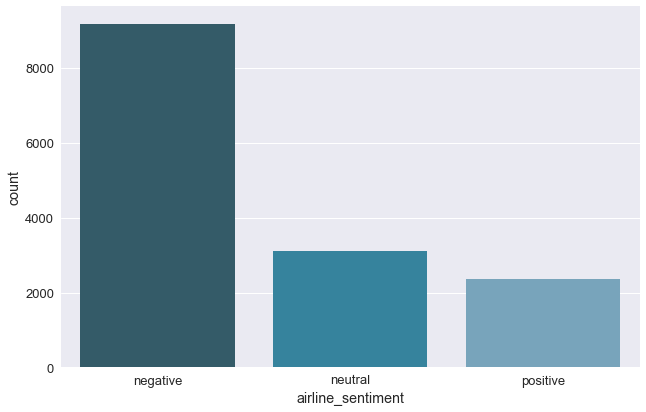

In [31]:
target_dist = sns.factorplot(x="airline_sentiment", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();
if not KAGGLE_ENV: target_dist.savefig('../output/target_dist.png')

## Text variable
To analyze the text variable we create a class **TextCounts**. In this class we compute some basic statistics on the text variable. This class can be used later in a Pipeline, as well.

* **count_words** : number of words in the tweet
* **count_mentions** : referrals to other Twitter accounts, which are preceded by a @
* **count_hashtags** : number of tag words, preceded by a #
* **count_capital_words** : number of uppercase words, could be used to *"shout"* and express (negative) emotions
* **count_excl_quest_marks** : number of question or exclamation marks
* **count_urls** : number of links in the tweet, preceded by http(s)
* **count_emojis** : number of emoji, which might be a good indication of the sentiment

In [3]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [4]:
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
# Add airline_sentiment to df_eda
df_eda['airline_sentiment'] = df.airline_sentiment

It could be interesting to see how the TextStats variables relate to the class variable. Therefore we write a function **show_dist** that provides descriptive statistics and a plot per target class.

In [15]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', size=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()
    if not KAGGLE_ENV: g.savefig('../output/' + col + '_dist.png')

Descriptive stats for count_words
---------------------------------
                    count       mean       std  min   25%   50%   75%   max
airline_sentiment                                                          
negative           9178.0  20.387557  6.100020  2.0  17.0  22.0  25.0  35.0
neutral            3099.0  15.290094  7.150738  2.0  10.0  15.0  21.0  34.0
positive           2363.0  14.478206  7.266129  2.0  8.0   14.0  21.0  33.0


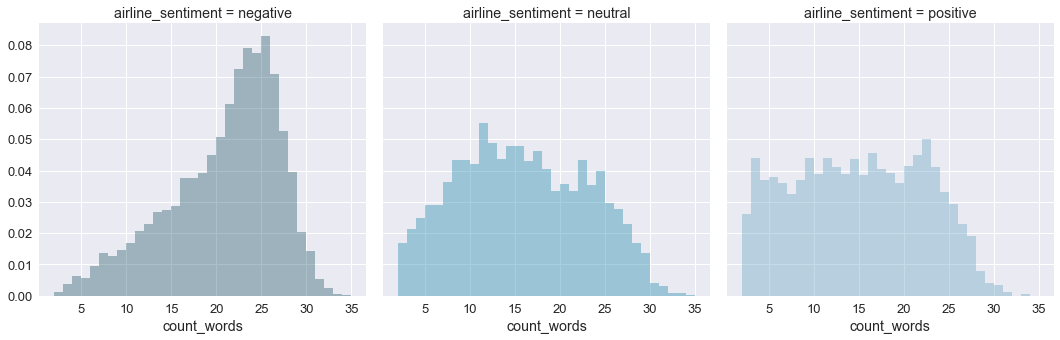

In [16]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_mentions
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  1.111244  0.365420  1.0  1.0  1.0  1.0  6.0
neutral            3099.0  1.167473  0.480102  1.0  1.0  1.0  1.0  5.0
positive           2363.0  1.138383  0.432462  1.0  1.0  1.0  1.0  6.0


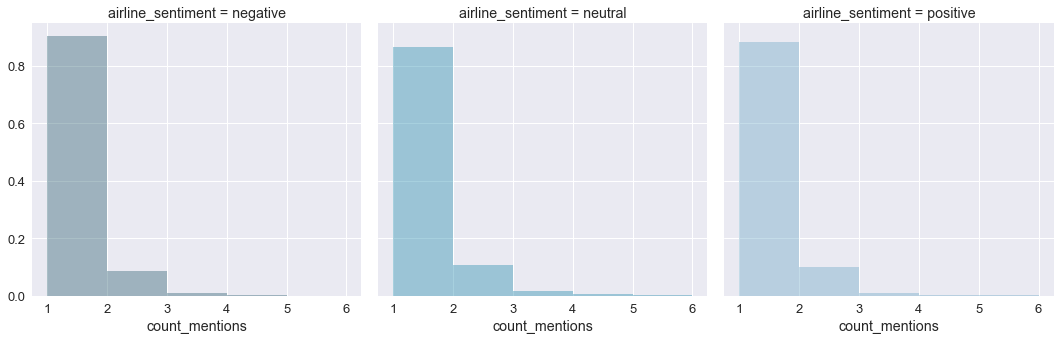

In [17]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.233384  0.615099  0.0  0.0  0.0  0.0  6.0
neutral            3099.0  0.212004  0.666382  0.0  0.0  0.0  0.0  6.0
positive           2363.0  0.297503  0.774776  0.0  0.0  0.0  0.0  8.0


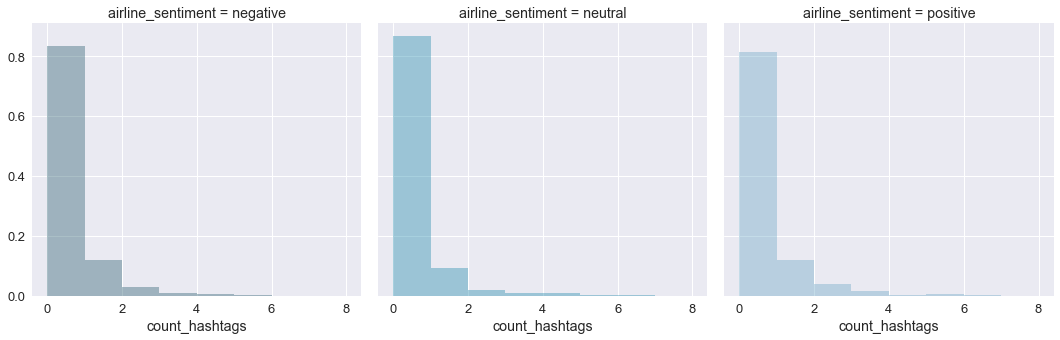

In [18]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.429070  1.019710  0.0  0.0  0.0  1.0  22.0
neutral            3099.0  0.462085  0.939468  0.0  0.0  0.0  1.0  11.0
positive           2363.0  0.461278  1.234078  0.0  0.0  0.0  1.0  20.0


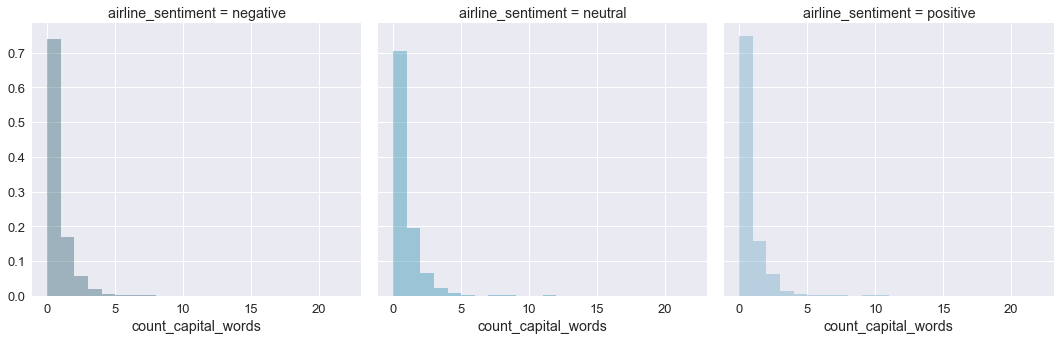

In [19]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.634125  1.143958  0.0  0.0  0.0  1.0  27.0
neutral            3099.0  0.665053  0.928761  0.0  0.0  0.0  1.0  12.0
positive           2363.0  0.892510  1.199191  0.0  0.0  1.0  1.0  13.0


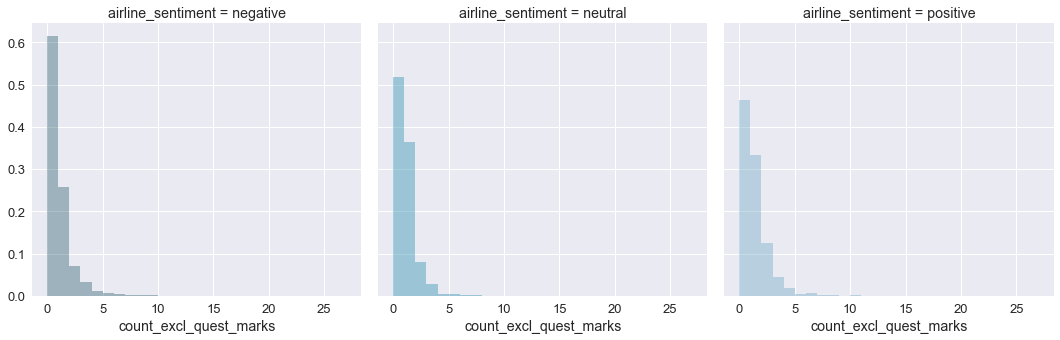

In [20]:
show_dist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           9178.0  0.049248  0.218403  0.0  0.0  0.0  0.0  2.0
neutral            3099.0  0.169732  0.401225  0.0  0.0  0.0  0.0  3.0
positive           2363.0  0.098603  0.303818  0.0  0.0  0.0  0.0  2.0


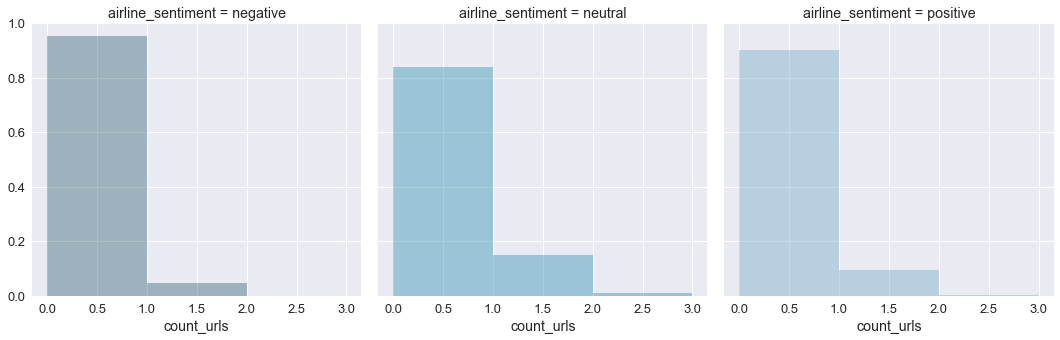

In [21]:
show_dist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           9178.0  0.028547  0.258772  0.0  0.0  0.0  0.0  8.0 
neutral            3099.0  0.075186  0.492514  0.0  0.0  0.0  0.0  13.0
positive           2363.0  0.179856  1.256408  0.0  0.0  0.0  0.0  40.0


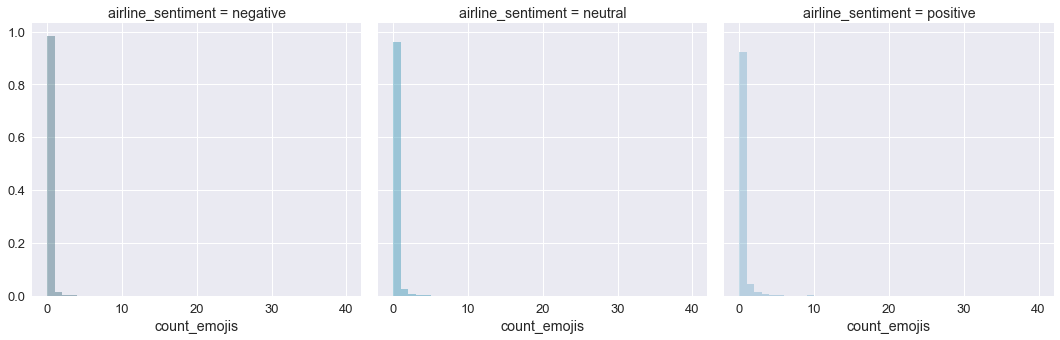

In [22]:
show_dist(df_eda, 'count_emojis')

**CONCLUSIONS: **
* **The number of words** used in the tweets is rater low. Maximum number of words is 36 and there are even tweets with only 2 words. So we'll have to be careful during data cleaning not to remove too many words. On the other hand, the text processing will be faster. Negative tweets contain more words than neutral or positive tweets.
* All tweets have at least one **mention**. Probably this is the result of extracting the tweets based on mentions in the Twitter data. There seems to be no difference in number of mentions with regard to the sentiment.
* Most of the tweets do not contain **hash tags**. So probably this variable will not be retained during model training. Again, no difference in number of hash tags with regard to the sentiment.
* Most of the tweets do not contain **capitalized words** and we do not see a difference in distribution between the sentiments.
* The positive tweets seem to be using a bit more **exclamation or question marks**.
* Most tweets do not contain a **URL**. 
* Most tweets do not use **emojis**.

# Text Cleaning
Before we start using the tweets' text we clean it. We'll do the this in the class CleanText:
- remove the **mentions**, as we want to make the model generalisable to tweets of other airline companies too.
- remove the **hash tag sign** (#) but not the actual tag as this may contain information
- set all words to **lowercase**
- remove all **punctuations**, including the question and exclamation marks
- remove the **urls** as they do not contain useful information and we did not notice a distinction in the number of urls used between the sentiment classes
- make sure the converted **emojis** are kept as one word. 
- remove **digits**
- remove **stopwords**
- apply the **PorterStemmer** to keep the stem of the words

In [5]:
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

To show how the cleaned text variable will look like, here's a sample.

In [6]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

12222    glad rt bet bird wish flown south winter                         
3936     point upc code check baggag tell luggag vacat day tri swimsuit   
367      vx jfk la dirti plane not standard                               
12257    tell mean work need estim time arriv pleas need laptop work thank
2957     sure busi go els airlin travel name kathryn sotelo               
Name: text, dtype: object

**NOTE: **One side-effect of text cleaning is that some rows do not have any words left in their text. For the CountVectorizer and TfIdfVectorizer this does not really pose a problem. However, for the Word2Vec algorithm this causes an error. There are different strategies that you could apply to deal with these missing values.

* Remove the complete row, but in a production environment this is not really desirable.
* Impute the missing value with some placeholder text like *[no_text]*
* Word2Vec: use the average of all vectors

Here we will impute with a placeholder text.

In [7]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

22 records have no words left after text cleaning


Now that we have the cleaned text of the tweets, we can have a look at what are the most frequent words. Below we'll show the top 20 words. 

**CONCLUSION: **Not surprisingly the most frequent word is *flight*.

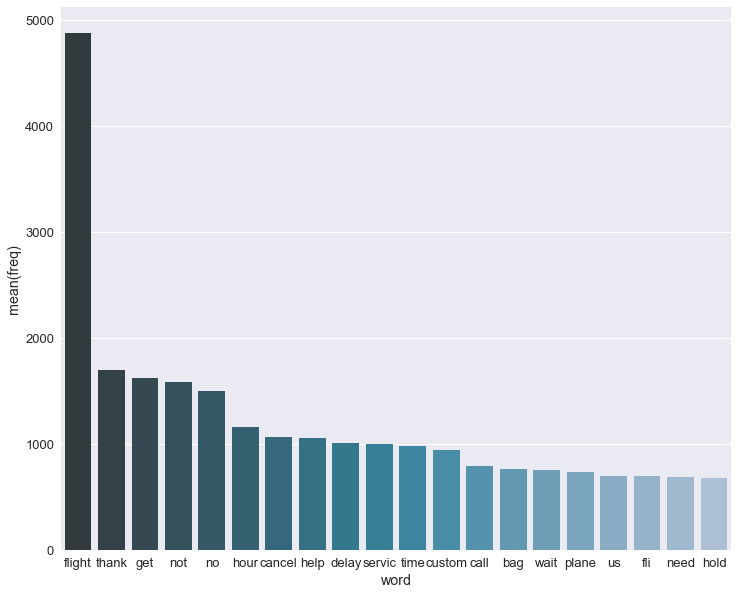

In [29]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();
if not KAGGLE_ENV: bar_freq_word.get_figure().savefig('../output/bar_freq_word.png')

# Creating test data
To evaluate the trained models we'll need a **test set**. Evaluating on the train data would not be correct because the models are trained to minimize their cost function. 

First we combine the TextCounts variables with the CleanText variable.

**NOTE: **Initially, I made the mistake to do execute TextCounts and CleanText in the GridSearchCV below. This took too long as it applies these functions each run of the GridSearch. It suffices to run them only once.

In [8]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_capital_words',
 'count_emojis',
 'count_excl_quest_marks',
 'count_hashtags',
 'count_mentions',
 'count_urls',
 'count_words',
 'airline_sentiment',
 'clean_text']

So df_model now contains several variables. However, our vectorizers (see below) will only need the *clean_text* variable. The TextCounts variables can be added as such. To specifically select columns, I wrote the class **ColumnExtractor** below. This can be used in the Pipeline afterwards.

In [9]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)

## Hyperparameter tuning and cross-validation
As we will see below, the vectorizers and classifiers all have configurable parameters. In order to chose the best parameters, we need to evaluate on a separate validation set that was not used during the training. However, using only one validation set may not produce reliable validation results. Due to chance you might have a good model performance on the validation set. If you would split the data otherwise, you might end up with other results. To get a more accurate estimation, we perform **cross-validation**. 

With cross-validation the data is split into a train and validation set multiple times. The evaluation metric is then averaged over the different folds. Luckily, GridSearchCV applies cross-validation out-of-the-box.

To find the best parameters for both a vectorizer and classifier, we create a **Pipeline**. All this is put into a function for ease of use.

### Evaluation metrics
By default GridSearchCV uses the default scorer to compute the *best_score_*. For both the MultiNomialNb and LogisticRegression this default scoring metric is the accuracy. 

In our function *grid_vect* we additionally generate the *classification_report* on the test data. This provides some interesting metrics **per target class**, which might be more appropriate here. These metrics are the **precision, recal and F1 score.**

* **Precision: ** Of all rows we predicted to be a certain class, how many did we correctly predict?
* **Recall: ** Of all rows of a certain class, how many did we correctly predict?
* **F1 score: ** Harmonic mean of Precision and Recall.

Precision and Recall can be calculated with the elements of the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

$Precision = {TP \over (TP + FP)}$

$Recall = {TP \over (TP + FN)}$

$F1 = {2*{(Precision*Recall) \over (Precision + Recall)}}$

In [18]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

### Parameter grids for GridSearchCV

In [11]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

## Classifiers
Here we will compare the performance of a MultinomailNB and LogisticRegression.

In [20]:
mnb = MultinomialNB()
logreg = LogisticRegression()

## CountVectorizer
To use words in a classifier, we need to convert the words to numbers. This can be done with a CountVectorizer. Sklearn's **CountVectorizer** takes all words in all tweets, assigns an ID and counts the frequency of the word per tweet. This *bag of words* can then be used as input for a classifier. It is what is called a **sparse** data set, meaning that each record will have many zeroes for the words not occurring in the tweet.

In [38]:
countvect = CountVectorizer()

In [40]:
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
if not KAGGLE_ENV: joblib.dump(best_mnb_countvect, '../output/best_mnb_countvect.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   59.4s finished


done in 60.722s

Best CV score: 0.778
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.803


Classification Report Test Data
             precision    recall  f1-score   support

   negative       0.84      0.92      0.87       924
    neutral       0.68      0.54      0.60       326
   positive       0.78      0.72      0.75       214

avg / total       0.79      0.80      0.80      1464



In [41]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
if not KAGGLE_ENV: joblib.dump(best_logreg_countvect, '../output/best_logreg_countvect.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.4min finished


done in 205.656s

Best CV score: 0.795
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.810


Classification Report Test Data
             precision    recall  f1-score   support

   negative       0.85      0.91      0.88       924
    neutral       0.70      0.60      0.64       326
   positive       0.77      0.69      0.73       214

avg / total       0.80      0.81      0.80      1464



## TF-IDF
One issue with CountVectorizer is that there might be words that occur frequently in observations of the target classes. These words do not have discriminatory information and can be removed. **TF-IDF (term frequency - inverse document frequency)** can be used to downweight these frequent words.

$tfidf(t,d) = tf(t,d)*idf(t,d)$

where tf(t,d) is the number of times term *t* occurs in document *d*. The inverse document frequency can be computed as follows:

$idf(t,d) = log{n_d \over 1 + df(d,t)}$

* $n_d$ is the number of documents
* df(d,t) is the number of documents that contain term *t*

We see that words that occur in many documents will have a low idf. By adding 1 to the denominator, we avoid having an idf equal to zero for words that occur in all documents.

In [42]:
tfidfvect = TfidfVectorizer()

In [43]:
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
if not KAGGLE_ENV: joblib.dump(best_mnb_tfidf, '../output/best_mnb_tfidf.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.0min finished


done in 62.946s

Best CV score: 0.749
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.750


Classification Report Test Data
             precision    recall  f1-score   support

   negative       0.76      0.96      0.84       924
    neutral       0.71      0.34      0.46       326
   positive       0.74      0.48      0.58       214

avg / total       0.74      0.75      0.72      1464



In [45]:
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
if not KAGGLE_ENV: joblib.dump(best_logreg_tfidf, '../output/best_logreg_tfidf.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.0min finished


done in 182.299s

Best CV score: 0.787
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.804


Classification Report Test Data
             precision    recall  f1-score   support

   negative       0.82      0.94      0.88       924
    neutral       0.73      0.54      0.62       326
   positive       0.79      0.60      0.68       214

avg / total       0.80      0.80      0.79      1464



## Word2Vec
Another way of converting the words in the tweets to numerical values can be achieved with Word2Vec. Word2Vec maps each word in a multi-dimensional space. It does this by taking into account the context in which a word appears in the tweets. As a result, words that are semantically similar are also close to each other in the multi-dimensional space. 

The Word2Vec algorithm is implemented in the [gensim](https://radimrehurek.com/gensim/models/word2vec.html) package.

The Word2Vec algorithm uses lists of words as input. For that purpose we use the **word_tokenize** method of the the nltk package.

In [27]:
SIZE = 25

X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))

model = gensim.models.Word2Vec(X_train.clean_text_wordlist
                 , min_count=1
                 , size=SIZE
                 , window=3
                 , workers=4)

In [28]:
model.most_similar('plane', topn=3)

[('tarmac', 0.9986330270767212),
 ('sit', 0.9983160495758057),
 ('still', 0.9978220462799072)]

The Word2Vec model provides a vocabulary of the words in the corpus together with their vector values. The number of vector values is equal to the chosen **size**. These are the dimensions on which each word is mapped in the multi-dimensional space.

Words with an occurrence less than **min_count** are not kept in the vocabulary. 
**NOTE: **A side effect of the **min_count** parameter is that some tweets could have no vector values. This is would be the case when the word(s) in the tweet occur in less than *min_count* tweets. Due to the small corpus of tweets, there is a risk of this happening in our case. Therefore we set the min_count value equal to 1.

The tweets can have a different number of vectors, depending on the number of words it contains. To use this output for modeling we will aggregate the vectors per tweet to have the same number (i.e. *size*) of input variables per tweet. Therefore we will take the average of all vectors per tweet. We do this with the function **compute_avg_w2v_vector**. In this function we also check whether the words in the tweet occur in the vocabulary of the word2vec model. If not, a list filled with 0.0 is returned. Else the average of the word vectors.

In [14]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result

In [29]:
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

This gives us a Series with a vector of dimension equal to SIZE. Now we will split this vector and create a DataFrame with each vector value in a separate column. That way we can concatenate the word2vec variables to the other TextCounts variables. We need to reuse the index of X_train and X_test respectively. Otherwise this will give issues (duplicates) in the concatenation later on.

In [30]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

**NOTE: **We only consider LogisticRegression as we have negative values in the Word2Vec vectors. MultinomialNB assumes that the variables have a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) which cannot contain negative values.

In [31]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)
if not KAGGLE_ENV: joblib.dump(best_logreg_w2v, '../output/best_logreg_w2v.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished


done in 133.297s

Best CV score: 0.715
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l1'
Test score with best_estimator_: 0.704


Classification Report Test Data
             precision    recall  f1-score   support

   negative       0.72      0.95      0.82       911
    neutral       0.61      0.27      0.37       320
   positive       0.68      0.36      0.47       233

avg / total       0.69      0.70      0.66      1464



## Conclusion
* Both classifiers achieve the best results when using the features of the CountVectorizer
* Overall, Logistic Regression outperforms the Multinomial Naive Bayes classifier
* The best performance on the test set comes from the LogisticRegression with features from CountVectorizer. 

Best parameters:
* C value of 1
* L2 regularization
* max_df: 0.5 or maximum document frequency of 50%.
* min_df: 1 or the words need to appear in at least 2 tweets
* ngram_range: (1, 2), both single words as bi-grams are used

Evaluation metrics:
* A **test accuracy** of 81,3%, which is better than what we would achieve by setting the prediction for all observations to the majority class (*negative* which would give 63% accuracy).
* The **Precision** is rather high for all three classes. For instance, of all cases that we predict as negative, 80% is indeed negative.
* The **Recall** for the neutral class is low. Of all neutral cases in our test data, we only predict 48% as being neutral.

# Apply the best model on new tweets
Just for the fun we will use the best model and apply it to some new tweets that contain *@VirginAmerica*. I selected 3 negative and 3 positive tweets by hand. 

Thanks to the GridSearchCV, we now know what are the best hyperparameters. So now we can train the best model on **all training data**, including the test data that we split off before.

In [32]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                         , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf', LogisticRegression(C=1.0, penalty='l2'))
])

best_model = pipeline.fit(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment)

## New positive tweets

In [33]:
new_positive_tweets = pd.Series(["Thank you @VirginAmerica for you amazing customer support team on Tuesday 11/28 at @EWRairport and returning my lost bag in less than 24h! #efficiencyiskey #virginamerica"
                      ,"Love flying with you guys ask these years.  Sad that this will be the last trip 😂   @VirginAmerica  #LuxuryTravel"
                      ,"Wow @VirginAmerica main cabin select is the way to fly!! This plane is nice and clean & I have tons of legroom! Wahoo! NYC bound! ✈️"])

df_counts_pos = tc.transform(new_positive_tweets)
df_clean_pos = ct.transform(new_positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos

best_model.predict(df_model_pos).tolist()

['positive', 'positive', 'positive']

## New negative tweets

In [34]:
new_negative_tweets = pd.Series(["@VirginAmerica shocked my initially with the service, but then went on to shock me further with no response to what my complaint was. #unacceptable @Delta @richardbranson"
                      ,"@VirginAmerica this morning I was forced to repack a suitcase w a medical device because it was barely overweight - wasn't even given an option to pay extra. My spouses suitcase then burst at the seam with the added device and had to be taped shut. Awful experience so far!"
                      ,"Board airplane home. Computer issue. Get off plane, traverse airport to gate on opp side. Get on new plane hour later. Plane too heavy. 8 volunteers get off plane. Ohhh the adventure of travel ✈️ @VirginAmerica"])

df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg

best_model.predict(df_model_neg).tolist()

['negative', 'negative', 'negative']

Great! The model classifies all of the tweets correctly. Obviously, a much larger test set should be used to correctly assess the model's performance.